<a href="https://colab.research.google.com/github/jafetimbre/optimus/blob/master/src/proj/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dask dask[dataframe] requests aiohttp sodapy fsspec partd hvplot -U -q

In [2]:
import pandas as pd
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import hvplot.dask
import seaborn as sns
import math

import dask 
import dask.dataframe as dd
import dask.bag as db

from sodapy import Socrata

In [3]:
socrata_client = Socrata("data.cityofchicago.org", None)
dask_bag = db.from_sequence(socrata_client.get("85ca-t3if", where="crash_date > '2020-01-01T00:00:00.000' AND crash_date < '2020-12-31T00:00:00.000'", content_type="json", limit=10000))

In [4]:
def to_props(record):
    return (
        record['crash_date'],
        record['date_police_notified'],
        str(record['crash_type']),
        int(record['num_units']),
        int(record['posted_speed_limit']),
        str(record['trafficway_type']),
        str(record['prim_contributory_cause']) if record['prim_contributory_cause'] not in ['UNABLE TO DETERMINE', 'NOT APPLICABLE'] else 'None',
        str(record['sec_contributory_cause']) if record['sec_contributory_cause'] not in ['UNABLE TO DETERMINE', 'NOT APPLICABLE'] else 'None',
        str(record['damage']),
        (True if record['hit_and_run_i'] == 'Y' else False) if 'hit_and_run_i' in record else 'False',
        str(record['lighting_condition']),
        str(record['road_defect']),
        str(record['weather_condition']),
        str(record['roadway_surface_cond']),
        float(record['injuries_incapacitating']) if 'injuries_incapacitating' in record else np.nan,
        float(record['injuries_fatal']) if 'injuries_fatal' in record else np.nan,
        float(record['injuries_total']) if 'injuries_fatal' in record else np.nan,
        float(record['latitude']) if 'latitude' in record else np.nan,
        float(record['longitude']) if 'longitude' in record else np.nan
    )

In [5]:
meta_types = {
    'crash_date': str,
    'date_police_notified': str,
    'crash_type': str,
    'num_units': int,
    'posted_speed_limit': int,
    'trafficway_type': str,
    'prim_contrib_cause': str,
    'sec_contrib_cause': str,
    'damage': str,
    'hit_and_run': bool,
    'lighting_condition': str,
    'road_defect': str,
    'weather_condition': str,
    'roadway_surface_cond': str,
    'injuries_incapacitating': float,
    'injuries_fatal': float,
    'injuries_total': float,
    'latitude': float,
    'longitude': float,
}

In [6]:
df = dask_bag.map(to_props).to_dataframe(meta=meta_types)

In [7]:
df['crash_date'] = dd.to_datetime(df['crash_date'])
df['date_police_notified'] = dd.to_datetime(df['date_police_notified'])

df = df.dropna().set_index('crash_date')
df.head()

,date_police_notified,crash_type,num_units,posted_speed_limit,trafficway_type,prim_contrib_cause,sec_contrib_cause,damage,hit_and_run,lighting_condition,road_defect,weather_condition,roadway_surface_cond,injuries_incapacitating,injuries_fatal,injuries_total,latitude,longitude
crash_date,,,,,,,,,,,,,,,,,,
2020-01-01 00:01:00,2020-01-01 14:30:00,NO INJURY / DRIVE AWAY,2,30,ONE-WAY,None,None,"$501 - $1,500",True,"DARKNESS, LIGHTED ROAD",NO DEFECTS,UNKNOWN,SNOW OR SLUSH,0.0,0.0,0.0,41.914563,-87.733948
2020-01-01 00:01:00,2020-01-01 09:57:00,INJURY AND / OR TOW DUE TO CRASH,1,25,NOT DIVIDED,None,None,"OVER $1,500",False,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,0.0,0.0,0.0,41.746329,-87.738093
2020-01-01 00:10:00,2020-01-01 00:10:00,NO INJURY / DRIVE AWAY,1,10,ALLEY,WEATHER,None,"OVER $1,500",True,"DARKNESS, LIGHTED ROAD",NO DEFECTS,CLEAR,ICE,0.0,0.0,0.0,41.869246,-87.744963
2020-01-01 00:12:00,2020-01-01 10:30:00,NO INJURY / DRIVE AWAY,2,25,NOT DIVIDED,IMPROPER BACKING,None,"$501 - $1,500",True,DARKNESS,NO DEFECTS,CLEAR,DRY,0.0,0.0,0.0,41.897781,-87.618080
2020-01-01 00:15:00,2020-01-01 00:33:00,INJURY AND / OR TOW DUE TO CRASH,2,30,NOT DIVIDED,None,None,"OVER $1,500",True,"DARKNESS, LIGHTED ROAD",UNKNOWN,CLEAR,SNOW OR SLUSH,0.0,0.0,0.0,41.799585,-87.683770


In [8]:
days = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun' ]
periods_of_day = {
    '0:00-3:00': (0, 3),
    '3:00-6:00': (3, 6),
    '6:00-9:00': (6, 9),
    '9:00-12:00': (9, 12),
    '12:00-15:00': (12, 15),
    '15:00-18:00': (15, 18),
    '18:00-21:00': (18, 21),
    '21:00-24:00': (21, 24),
}

def day_time(t):
    time = t.time()
    for key, val in periods_of_day.items():
        if (time >= dt.datetime(2009, 12, 2, val[0], 00, 00, 000000).time() and 
            time <= dt.datetime(2009, 12, 2, val[1]-1, 59, 00, 000000).time()):
            return key


d = df.copy()
d['police_response_time'] = d['date_police_notified'] - d.index
d['police_response_time'] = d['police_response_time'].map(lambda t: round(t.seconds/3600, 2))
d['daytime'] = d.index
d['day'] = d['daytime'].map(lambda t: days[t.weekday()])
d['period_of_day'] = d['daytime'].map(day_time)

d.head()

,date_police_notified,crash_type,num_units,posted_speed_limit,trafficway_type,prim_contrib_cause,sec_contrib_cause,damage,hit_and_run,lighting_condition,road_defect,weather_condition,roadway_surface_cond,injuries_incapacitating,injuries_fatal,injuries_total,latitude,longitude,police_response_time,daytime,day,period_of_day
crash_date,,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:01:00,2020-01-01 14:30:00,NO INJURY / DRIVE AWAY,2,30,ONE-WAY,None,None,"$501 - $1,500",True,"DARKNESS, LIGHTED ROAD",NO DEFECTS,UNKNOWN,SNOW OR SLUSH,0.0,0.0,0.0,41.914563,-87.733948,14.48,2020-01-01 00:01:00,Wed,0:00-3:00
2020-01-01 00:01:00,2020-01-01 09:57:00,INJURY AND / OR TOW DUE TO CRASH,1,25,NOT DIVIDED,None,None,"OVER $1,500",False,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,0.0,0.0,0.0,41.746329,-87.738093,9.93,2020-01-01 00:01:00,Wed,0:00-3:00
2020-01-01 00:10:00,2020-01-01 00:10:00,NO INJURY / DRIVE AWAY,1,10,ALLEY,WEATHER,None,"OVER $1,500",True,"DARKNESS, LIGHTED ROAD",NO DEFECTS,CLEAR,ICE,0.0,0.0,0.0,41.869246,-87.744963,0.00,2020-01-01 00:10:00,Wed,0:00-3:00
2020-01-01 00:12:00,2020-01-01 10:30:00,NO INJURY / DRIVE AWAY,2,25,NOT DIVIDED,IMPROPER BACKING,None,"$501 - $1,500",True,DARKNESS,NO DEFECTS,CLEAR,DRY,0.0,0.0,0.0,41.897781,-87.618080,10.30,2020-01-01 00:12:00,Wed,0:00-3:00
2020-01-01 00:15:00,2020-01-01 00:33:00,INJURY AND / OR TOW DUE TO CRASH,2,30,NOT DIVIDED,None,None,"OVER $1,500",True,"DARKNESS, LIGHTED ROAD",UNKNOWN,CLEAR,SNOW OR SLUSH,0.0,0.0,0.0,41.799585,-87.683770,0.30,2020-01-01 00:15:00,Wed,0:00-3:00


In [9]:
d = d.compute()

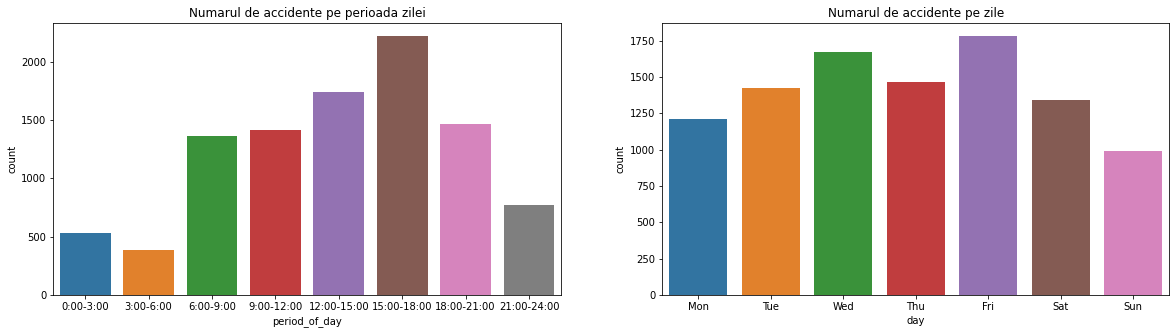

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].set_title('Numarul de accidente pe perioada zilei')
sns.countplot(x='period_of_day', data = d, order=periods_of_day.keys(), ax=ax[0])

ax[1].set_title('Numarul de accidente pe zile')
sns.countplot(x='day', data = d, order=days, ax=ax[1])

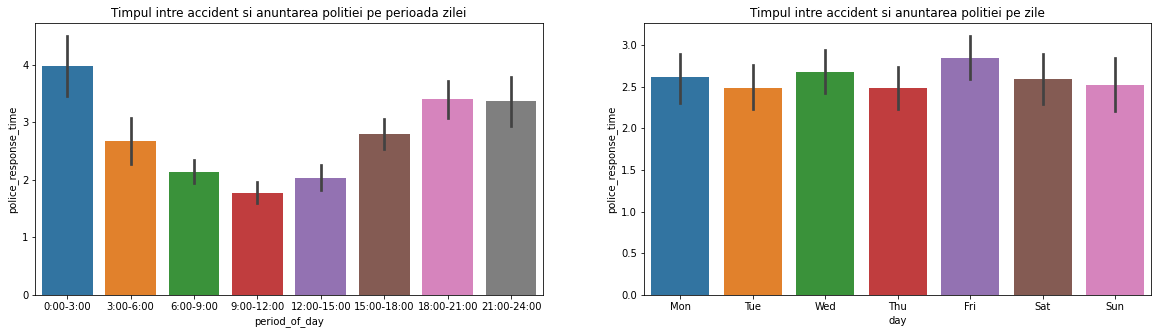

In [11]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].set_title('Timpul intre accident si anuntarea politiei pe perioada zilei')
sns.barplot(x='period_of_day', y="police_response_time", data = d, order=periods_of_day.keys(), ax=ax[0])

ax[1].set_title('Timpul intre accident si anuntarea politiei pe zile')
sns.barplot(x="day", y="police_response_time", data=d, estimator=np.mean, order=days, ax=ax[1])

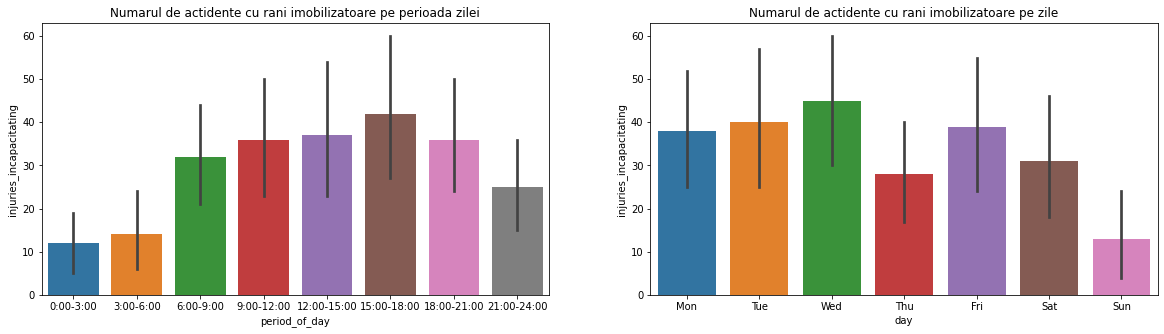

In [12]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].set_title('Numarul de actidente cu rani imobilizatoare pe perioada zilei')
sns.barplot(x='period_of_day', y="injuries_incapacitating", data=d, estimator=np.sum, order=periods_of_day.keys(), ax=ax[0])

ax[1].set_title('Numarul de actidente cu rani imobilizatoare pe zile')
sns.barplot(x="day", y="injuries_incapacitating", data=d, estimator=np.sum, order=days, ax=ax[1])

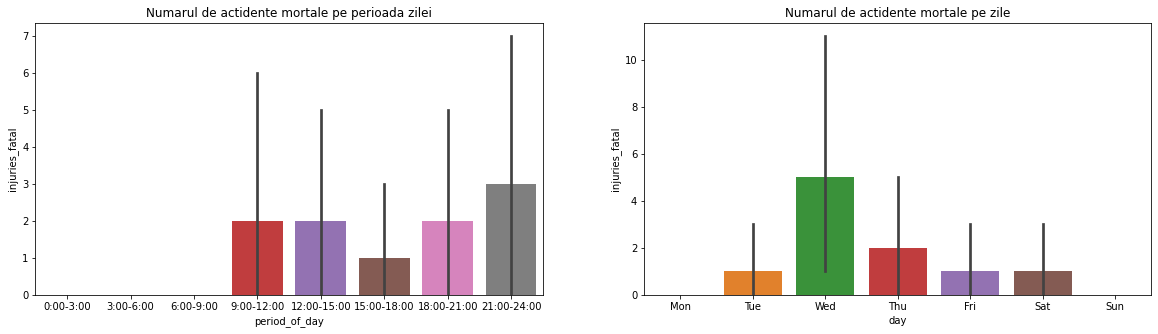

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].set_title('Numarul de actidente mortale pe perioada zilei')
sns.barplot(x='period_of_day', y="injuries_fatal", data=d, estimator=np.sum, order=periods_of_day.keys(), ax=ax[0])

ax[1].set_title('Numarul de actidente mortale pe zile')
sns.barplot(x="day", y="injuries_fatal", data=d, estimator=np.sum, order=days, ax=ax[1])

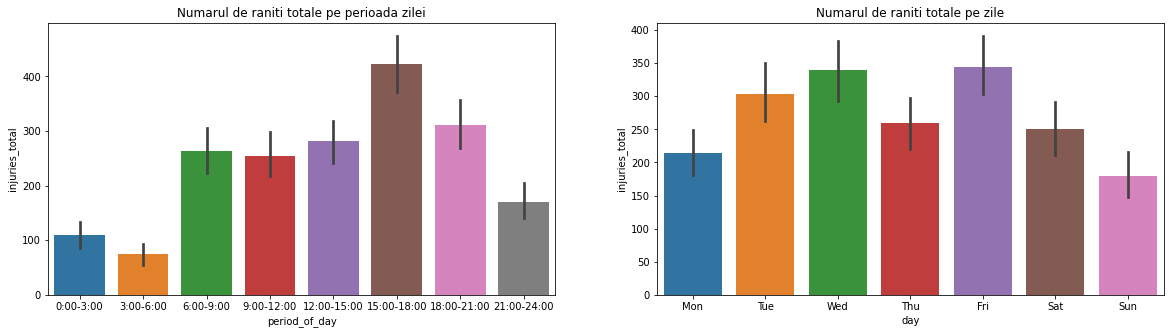

In [14]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].set_title('Numarul de raniti totale pe perioada zilei')
sns.barplot(x='period_of_day', y="injuries_total", data=d, estimator=np.sum, order=periods_of_day.keys(), ax=ax[0])

ax[1].set_title('Numarul de raniti totale pe zile')
sns.barplot(x="day", y="injuries_total", data=d, estimator=np.sum, order=days, ax=ax[1])

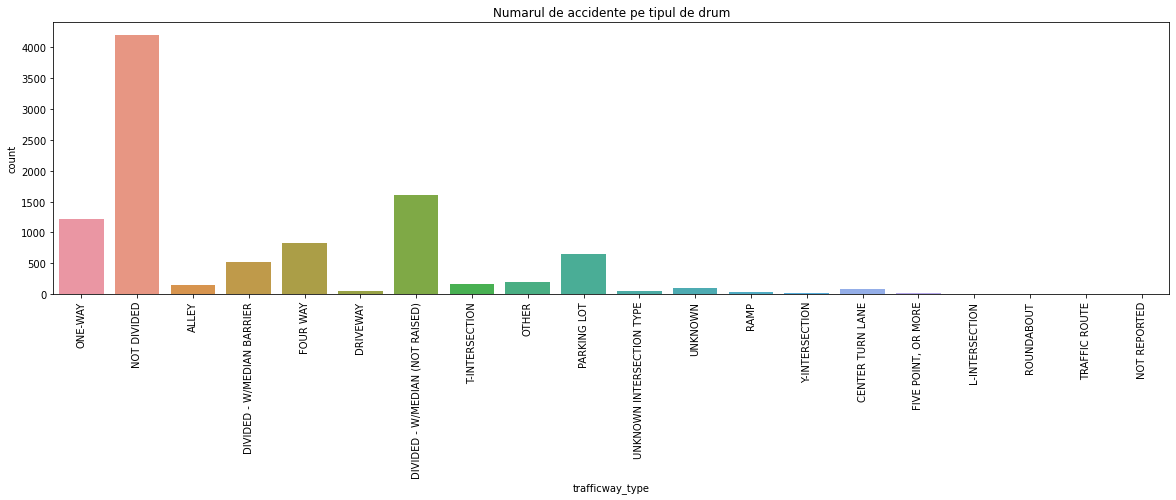

In [15]:
fig, ax = plt.subplots(figsize=(20,5))

ax.set_title('Numarul de accidente pe tipul de drum')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.countplot(x='trafficway_type', data = d, ax=ax)


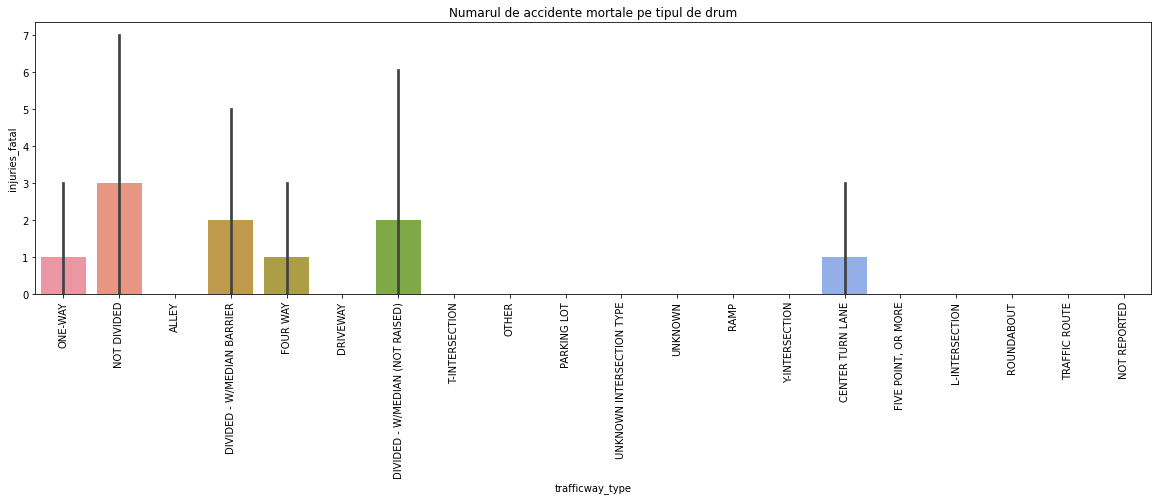

In [16]:
fig, ax = plt.subplots(figsize=(20,5))

ax.set_title('Numarul de accidente mortale pe tipul de drum')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.barplot(x='trafficway_type', y='injuries_fatal', data = d, estimator=np.sum, ax=ax)

In [17]:
d.head()

,date_police_notified,crash_type,num_units,posted_speed_limit,trafficway_type,prim_contrib_cause,sec_contrib_cause,damage,hit_and_run,lighting_condition,road_defect,weather_condition,roadway_surface_cond,injuries_incapacitating,injuries_fatal,injuries_total,latitude,longitude,police_response_time,daytime,day,period_of_day
crash_date,,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:01:00,2020-01-01 14:30:00,NO INJURY / DRIVE AWAY,2,30,ONE-WAY,None,None,"$501 - $1,500",True,"DARKNESS, LIGHTED ROAD",NO DEFECTS,UNKNOWN,SNOW OR SLUSH,0.0,0.0,0.0,41.914563,-87.733948,14.48,2020-01-01 00:01:00,Wed,0:00-3:00
2020-01-01 00:01:00,2020-01-01 09:57:00,INJURY AND / OR TOW DUE TO CRASH,1,25,NOT DIVIDED,None,None,"OVER $1,500",False,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,0.0,0.0,0.0,41.746329,-87.738093,9.93,2020-01-01 00:01:00,Wed,0:00-3:00
2020-01-01 00:10:00,2020-01-01 00:10:00,NO INJURY / DRIVE AWAY,1,10,ALLEY,WEATHER,None,"OVER $1,500",True,"DARKNESS, LIGHTED ROAD",NO DEFECTS,CLEAR,ICE,0.0,0.0,0.0,41.869246,-87.744963,0.00,2020-01-01 00:10:00,Wed,0:00-3:00
2020-01-01 00:12:00,2020-01-01 10:30:00,NO INJURY / DRIVE AWAY,2,25,NOT DIVIDED,IMPROPER BACKING,None,"$501 - $1,500",True,DARKNESS,NO DEFECTS,CLEAR,DRY,0.0,0.0,0.0,41.897781,-87.618080,10.30,2020-01-01 00:12:00,Wed,0:00-3:00
2020-01-01 00:15:00,2020-01-01 00:33:00,INJURY AND / OR TOW DUE TO CRASH,2,30,NOT DIVIDED,None,None,"OVER $1,500",True,"DARKNESS, LIGHTED ROAD",UNKNOWN,CLEAR,SNOW OR SLUSH,0.0,0.0,0.0,41.799585,-87.683770,0.30,2020-01-01 00:15:00,Wed,0:00-3:00


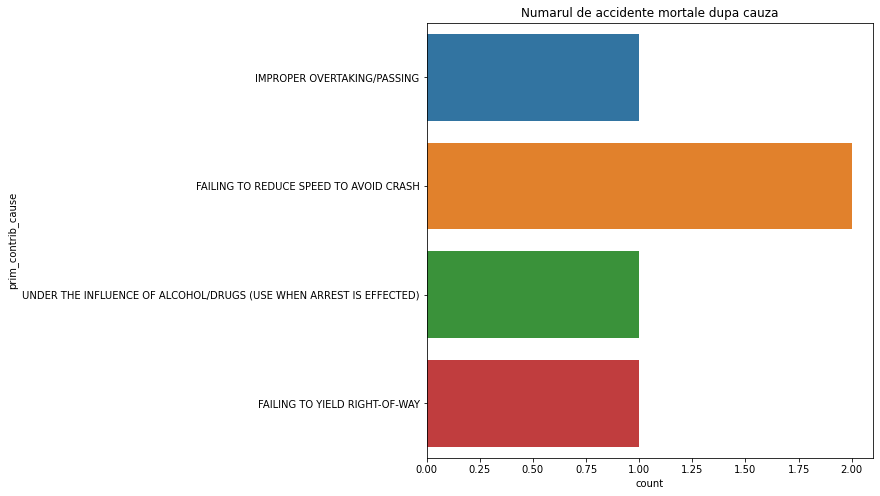

In [18]:
fig, ax = plt.subplots(figsize=(8,8))

ax.set_title('Numarul de accidente mortale dupa cauza')
sns.countplot(y='prim_contrib_cause', data=d[(d['prim_contrib_cause'] != 'None') & (d['injuries_fatal'] > 0)], ax=ax)

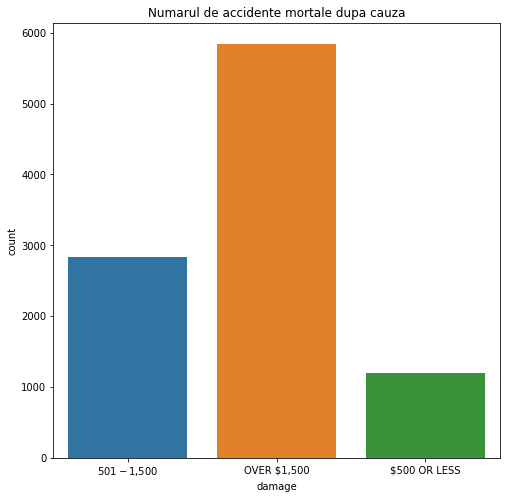

In [19]:
fig, ax = plt.subplots(figsize=(8,8))

ax.set_title('Numarul de accidente mortale dupa cauza')
sns.countplot(x='damage', data=d, ax=ax)

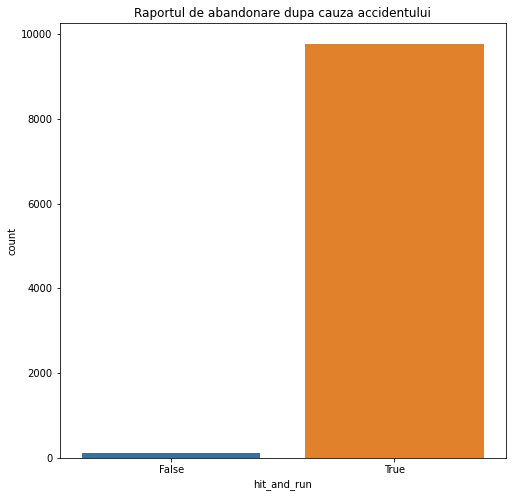

In [20]:
fig, ax = plt.subplots(figsize=(8,8))

ax.set_title('Raportul de abandonare dupa cauza accidentului')
sns.countplot(x='hit_and_run', data=d, ax=ax)

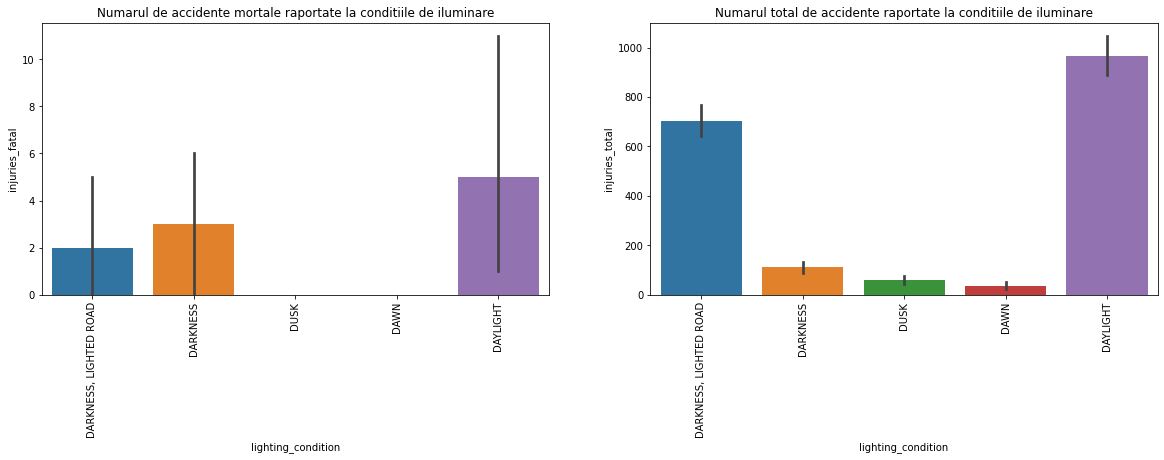

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0].set_title('Numarul de accidente mortale raportate la conditiile de iluminare')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
sns.barplot(x='lighting_condition', y='injuries_fatal', estimator=np.sum, data=d[(d['lighting_condition'] != 'UNKNOWN')], ax=ax[0]) 

ax[1].set_title('Numarul total de accidente raportate la conditiile de iluminare')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
sns.barplot(x='lighting_condition', y='injuries_total', estimator=np.sum, data=d[(d['lighting_condition'] != 'UNKNOWN')], ax=ax[1]) 

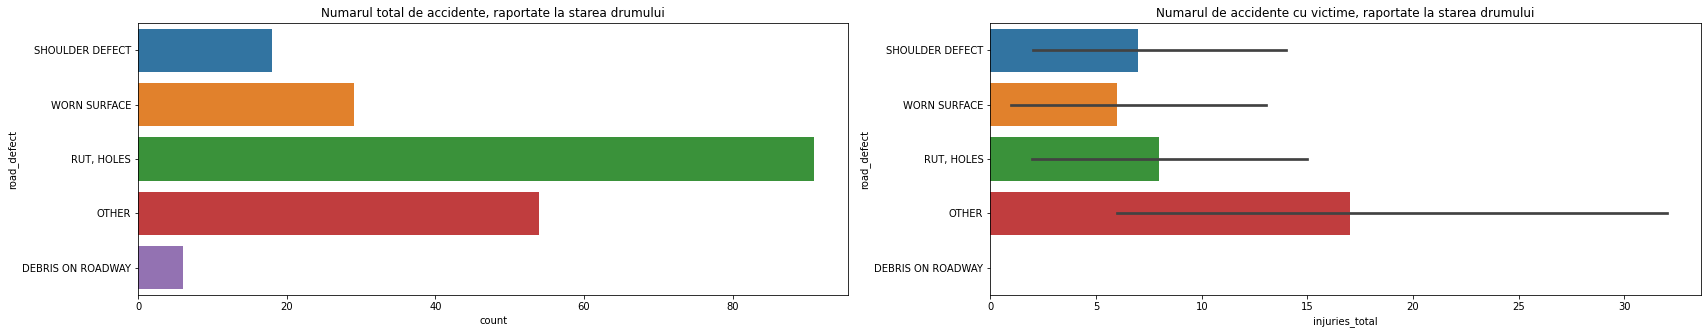

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(28,5))

ax[0].set_title('Numarul total de accidente, raportate la starea drumului')
sns.countplot(y='road_defect', data=d[(d['road_defect'] != 'UNKNOWN') & (d['road_defect'] != 'NO DEFECTS')], ax=ax[0]) 

ax[1].set_title('Numarul de accidente cu victime, raportate la starea drumului')
sns.barplot(x='injuries_total', y='road_defect', estimator=np.sum, data=d[(d['road_defect'] != 'UNKNOWN') & (d['road_defect'] != 'NO DEFECTS')], ax=ax[1]) 

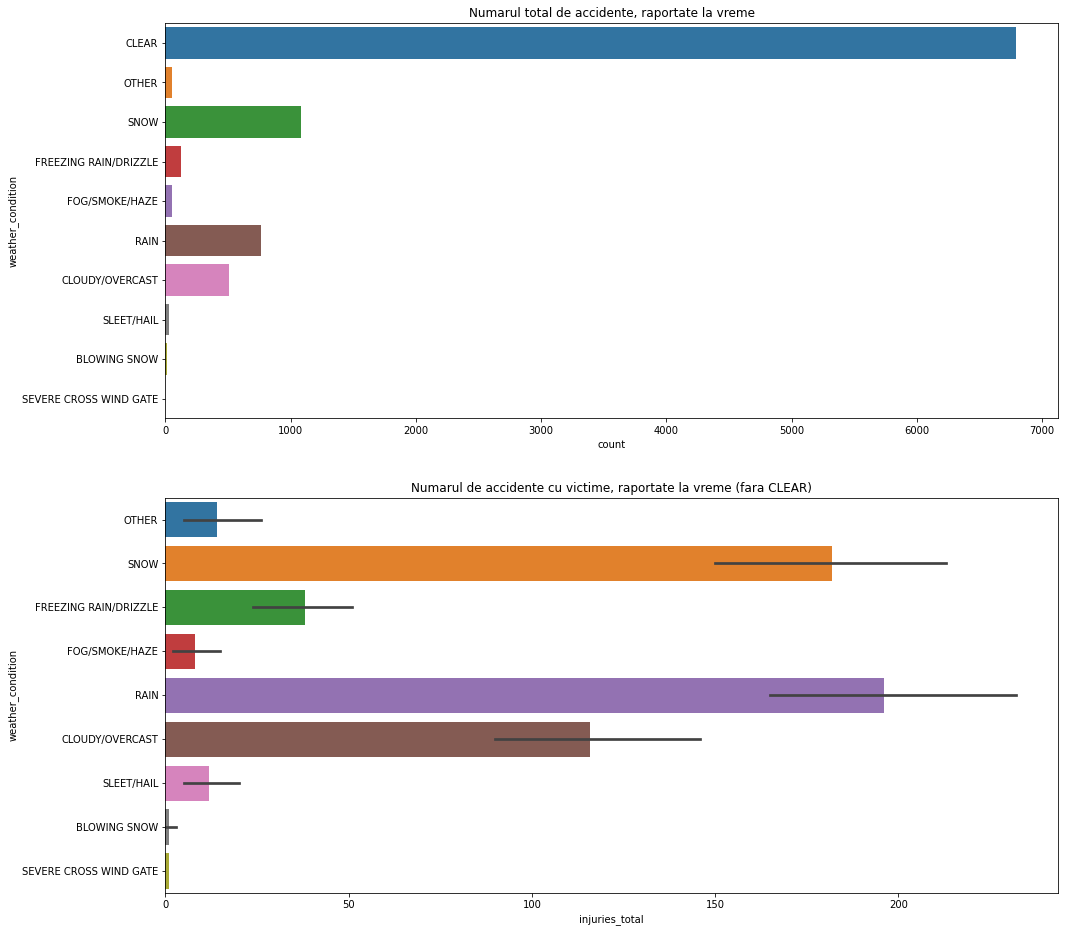

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(16,16))

ax[0].set_title('Numarul total de accidente, raportate la vreme')
sns.countplot(y='weather_condition', data=d[(d['weather_condition'] != 'UNKNOWN')], ax=ax[0]) 

ax[1].set_title('Numarul de accidente cu victime, raportate la vreme (fara CLEAR)')
sns.barplot(x='injuries_total', y='weather_condition', estimator=np.sum, data=d[(d['weather_condition'] != 'CLEAR') & (d['weather_condition'] != 'UNKNOWN')], ax=ax[1]) 

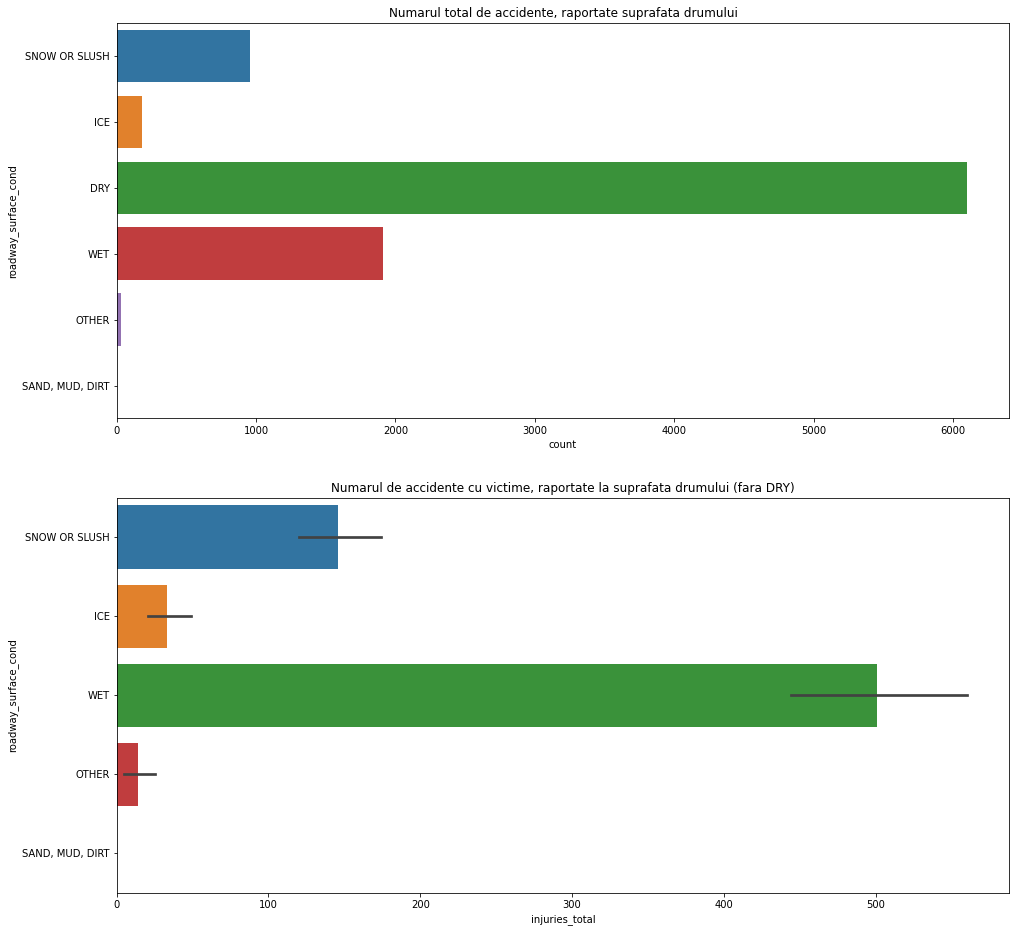

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(16,16))

ax[0].set_title('Numarul total de accidente, raportate suprafata drumului')
sns.countplot(y='roadway_surface_cond', data=d[(d['roadway_surface_cond'] != 'UNKNOWN')], ax=ax[0]) 

ax[1].set_title('Numarul de accidente cu victime, raportate la suprafata drumului (fara DRY)')
sns.barplot(x='injuries_total', y='roadway_surface_cond', estimator=np.sum, data=d[(d['roadway_surface_cond'] != 'DRY') & (d['roadway_surface_cond'] != 'UNKNOWN')], ax=ax[1])